# Time Series Prediction with LSTM RNN using Kears
### Source
* https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

Time series prediction problems are a difficult type of predictive modeling problem. Unlike regression predictive modeling, time series also **adds the complexity of a sequence dependence among the input variables.** A powerful type of neural network designed to handle sequence dependence is called RNN. The LSTM network is a type of RNN used in deep learning because very large architectures can be successfully trained. 

In [2]:
import pandas as pd
data = pd.read_csv('../data/AirPassengers.csv', usecols=[1]) # we will omit dates

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

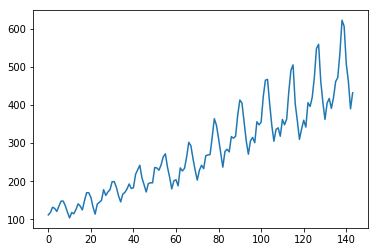

In [4]:
plt.plot(data['#Passengers'])

You can see an upward trend in the dataset over time.  

## 1. LSTM Network
LSTM network is a RNN that is trained using backpropagation through time and overcomes the vanishing gradient problem. As such, it can be used to create large RNN that in turn can be used to address difficult sequence problems in ML and achieve state-of-the-art results. 

Instead of neurons, LSTM networks have memory blocks that are connectd through layers. A block has components that make it smarter than a classicial neuron and a memory for recent sequences. A block contains gates that manage the block's state and output. A block operates upon an input sequence and each gate with a block uses the sigmoid activation units to control whether they are triggered or not, making the change of state and addition of information flowing through the block conditional. 

There are three types of gates within a unit:
* **Forget gate**: conditionally decides what information to throw away from the block. 
* **Input gate**: conditionally decides which values from the input to update the memory state.
* **Output gate**: conditionally decides what to output based on input and the memory of the block.

Each unit is like a mini-state machine where the gates of the units have weights that are learned during the training procedure. 

In [5]:
import numpy as np
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [7]:
# Fix random number seed for reproducibility
np.random.seed(8)

In [8]:
dataset=data.values
dataset=dataset.astype('float32')

LSTMs are sensitive to the scale of the input data, specifically when the sigmoid or tanh activation functions are used. It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing. We can easily normalize the dataset using the **MinMaxScaler** preprocessing class from the scikit-learn library.

In [9]:
# normalize dataset
scaler = MinMaxScaler(feature_range=(0,1))
dataset=scaler.fit_transform(dataset)

With the ts data, the sequence of values is important. We will split the dataset and then create the dataset using sequences.

In [10]:
# split into train and test data sets.
train_size = int(len(dataset)* 0.67)
test_size = len(dataset)-train_size
train,test=dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

96 48


The following function takes two arguments: the dataset, which is a NumPy array that we want to convert into a dataset, and the look_back, which is the number of previous time stepts to use as input variables to predict the next time period - i nthis case defaulted to 1. 

In [11]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    """
    Convert an array of values into a dataset matrix for ts.
    """
    dataX, dataY = [],[]
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i+look_back, 0])
    return np.array(dataX), np.array(dataY)

In [12]:
look_back=1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

The LSTM network expects the input data(x) to be provided with a specific array structure in the form of: samples, time steps, features. Currently, our data is in the form of samples, features. We can transform the preprared train and test input data into the expected structure. 

In [13]:
# reshape input to be [samples, time steps, features]
trainX=np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX=np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a single value prediction. The defautl sigmoid activation function is used for the LSTM blocks. 

In [14]:
def fit_lstm(trainX, trainY, epochs=100, batch_size=1, verbose=2):
    model=Sequential()
    model.add(LSTM(4, input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

In [15]:
lstm_model = fit_lstm(trainX, trainY)

Epoch 1/100
 - 1s - loss: 0.0221
Epoch 2/100
 - 0s - loss: 0.0101
Epoch 3/100
 - 0s - loss: 0.0087
Epoch 4/100
 - 0s - loss: 0.0079
Epoch 5/100
 - 0s - loss: 0.0072
Epoch 6/100
 - 0s - loss: 0.0065
Epoch 7/100
 - 0s - loss: 0.0056
Epoch 8/100
 - 0s - loss: 0.0049
Epoch 9/100
 - 0s - loss: 0.0043
Epoch 10/100
 - 0s - loss: 0.0038
Epoch 11/100
 - 0s - loss: 0.0034
Epoch 12/100
 - 0s - loss: 0.0030
Epoch 13/100
 - 0s - loss: 0.0027
Epoch 14/100
 - 0s - loss: 0.0025
Epoch 15/100
 - 0s - loss: 0.0024
Epoch 16/100
 - 0s - loss: 0.0023
Epoch 17/100
 - 0s - loss: 0.0022
Epoch 18/100
 - 0s - loss: 0.0021
Epoch 19/100
 - 0s - loss: 0.0020
Epoch 20/100
 - 0s - loss: 0.0021
Epoch 21/100
 - 0s - loss: 0.0021
Epoch 22/100
 - 0s - loss: 0.0021
Epoch 23/100
 - 0s - loss: 0.0021
Epoch 24/100
 - 0s - loss: 0.0020
Epoch 25/100
 - 0s - loss: 0.0021
Epoch 26/100
 - 0s - loss: 0.0020
Epoch 27/100
 - 0s - loss: 0.0021
Epoch 28/100
 - 0s - loss: 0.0020
Epoch 29/100
 - 0s - loss: 0.0020
Epoch 30/100
 - 0s - lo

Once the model is fit, we can estimate the performance of the model on the train and test datasets. This will give us a point of comparison for new models. Note that we invert the predictions before calculating error scores to ensure that performance is reported in the same units as the original data(thousands of passengers per month).

In [16]:
# make predictions.
trainPredict=lstm_model.predict(trainX)
testPredict=lstm_model.predict(testX)

# invert predictions.
trainPredict=scaler.inverse_transform(trainPredict)
trainY=scaler.inverse_transform([trainY])
testPredict=scaler.inverse_transform(testPredict)
testY=scaler.inverse_transform([testY])

In [17]:
# calculate root mean squared error
trainScore=math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train score: %.2f RMSE'%(trainScore))
testScore=math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test score: %.2f RMSE'%(testScore))

Train score: 22.77 RMSE
Test score: 48.21 RMSE


Finally, we can generate predictions using the model for both the train and test dataset to get a visual indication of the skill of the model. Because of how the dataset was prepared, we must shift the predictions so that they align on the x-axis with the orignal dataset. Once prepared, the data is plotted, showing the original dataset in blue, the predictions for the training dataset in orange, and the predictions on the unseen test dataset in green.

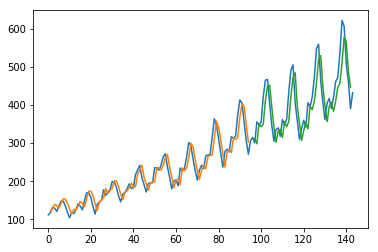

In [18]:
# shift train predictions for plotting
trainPredictPlot=np.empty_like(dataset)
trainPredictPlot[:,:]=np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot=np.empty_like(dataset)
testPredictPlot[:,:]=np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1,:]=testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## 2. LSTM for regression using the window method
We can also phrase the problem so that multiple, recent time steps can be used tomake the prediction for the next time step. This is called a window, and the size of the window is a parameter that can be tuned for each problem.

In [19]:
look_back=3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [23]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [26]:
lstm_model = fit_lstm(trainX, trainY)

Epoch 1/100
 - 1s - loss: 0.0461
Epoch 2/100
 - 0s - loss: 0.0193
Epoch 3/100
 - 0s - loss: 0.0130
Epoch 4/100
 - 0s - loss: 0.0113
Epoch 5/100
 - 0s - loss: 0.0100
Epoch 6/100
 - 0s - loss: 0.0088
Epoch 7/100
 - 0s - loss: 0.0077
Epoch 8/100
 - 0s - loss: 0.0068
Epoch 9/100
 - 0s - loss: 0.0060
Epoch 10/100
 - 0s - loss: 0.0053
Epoch 11/100
 - 0s - loss: 0.0048
Epoch 12/100
 - 0s - loss: 0.0044
Epoch 13/100
 - 0s - loss: 0.0042
Epoch 14/100
 - 0s - loss: 0.0040
Epoch 15/100
 - 0s - loss: 0.0039
Epoch 16/100
 - 0s - loss: 0.0038
Epoch 17/100
 - 0s - loss: 0.0038
Epoch 18/100
 - 0s - loss: 0.0037
Epoch 19/100
 - 0s - loss: 0.0036
Epoch 20/100
 - 0s - loss: 0.0036
Epoch 21/100
 - 0s - loss: 0.0037
Epoch 22/100
 - 0s - loss: 0.0036
Epoch 23/100
 - 0s - loss: 0.0035
Epoch 24/100
 - 0s - loss: 0.0035
Epoch 25/100
 - 0s - loss: 0.0035
Epoch 26/100
 - 0s - loss: 0.0035
Epoch 27/100
 - 0s - loss: 0.0034
Epoch 28/100
 - 0s - loss: 0.0034
Epoch 29/100
 - 0s - loss: 0.0034
Epoch 30/100
 - 0s - lo

In [27]:
# make predictions.
trainPredict=lstm_model.predict(trainX)
testPredict=lstm_model.predict(testX)

# invert predictions.
trainPredict=scaler.inverse_transform(trainPredict)
trainY=scaler.inverse_transform([trainY])
testPredict=scaler.inverse_transform(testPredict)
testY=scaler.inverse_transform([testY])

In [28]:
# calculate root mean squared error
trainScore=math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train score: %.2f RMSE'%(trainScore))
testScore=math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test score: %.2f RMSE'%(testScore))

Train score: 24.38 RMSE
Test score: 54.15 RMSE


We can see that the error was increased slightly compared to that of the previous section. It is because the window size and the network architecture were not tuned.

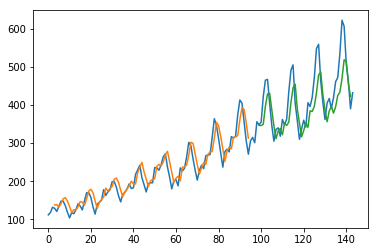

In [29]:
# shift train predictions for plotting
trainPredictPlot=np.empty_like(dataset)
trainPredictPlot[:,:]=np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot=np.empty_like(dataset)
testPredictPlot[:,:]=np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1,:]=testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## 3. LSTM with memory between batches
The LSTM network ahs memory, which is capable of remembering across long sequences. Normally, the state within the network is reset after each training batch when fitting the model, as well as each call to model.predict() or model.evaluate(). 

We can gain a finer control over when the internal state of LSTM network is cleared in Keras by making the LSTM layer "stateful." This means that it can build state over the entire training sequence and even maintain the state if needed to make predictions.

It requires that the training data not be shuffled when fitting the network. It also requires explicit resetting of the network state after each exposure to the training data(epoch) by calls to model.reset_states(). This means that we must create our own outer loop of epochs and within each epoch call model.fit() and model.reset_state(). 

Finally, when the LSTM layer is constructed, the stateful parameter must be set to **True** and instead of specifying the input dimensions, we must hard code the number of samples in a batch, number of time steps in a sample and number of features in a time step by setting the batch_input_shape parameter.

In [31]:
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [32]:
def fit_lstm_2(trainX, trainY, epochs=100, batch_size=1, verbose=2):
    model=Sequential()
    model.add(LSTM(4, batch_input_shape = (batch_size, look_back, 1), stateful = True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(epochs):
        model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=verbose, shuffle=False)
        model.reset_states()
    return model

In [33]:
lstm_model = fit_lstm_2(trainX, trainY)

Epoch 1/1
 - 1s - loss: 0.0101
Epoch 1/1
 - 0s - loss: 0.0129
Epoch 1/1
 - 0s - loss: 0.0090
Epoch 1/1
 - 0s - loss: 0.0072
Epoch 1/1
 - 0s - loss: 0.0061
Epoch 1/1
 - 0s - loss: 0.0055
Epoch 1/1
 - 0s - loss: 0.0052
Epoch 1/1
 - 0s - loss: 0.0050
Epoch 1/1
 - 0s - loss: 0.0049
Epoch 1/1
 - 0s - loss: 0.0048
Epoch 1/1
 - 0s - loss: 0.0047
Epoch 1/1
 - 0s - loss: 0.0047
Epoch 1/1
 - 0s - loss: 0.0046
Epoch 1/1
 - 0s - loss: 0.0046
Epoch 1/1
 - 0s - loss: 0.0045
Epoch 1/1
 - 0s - loss: 0.0045
Epoch 1/1
 - 0s - loss: 0.0045
Epoch 1/1
 - 0s - loss: 0.0044
Epoch 1/1
 - 0s - loss: 0.0044
Epoch 1/1
 - 0s - loss: 0.0044
Epoch 1/1
 - 0s - loss: 0.0043
Epoch 1/1
 - 0s - loss: 0.0043
Epoch 1/1
 - 0s - loss: 0.0043
Epoch 1/1
 - 0s - loss: 0.0043
Epoch 1/1
 - 0s - loss: 0.0042
Epoch 1/1
 - 0s - loss: 0.0042
Epoch 1/1
 - 0s - loss: 0.0042
Epoch 1/1
 - 0s - loss: 0.0042
Epoch 1/1
 - 0s - loss: 0.0042
Epoch 1/1
 - 0s - loss: 0.0041
Epoch 1/1
 - 0s - loss: 0.0041
Epoch 1/1
 - 0s - loss: 0.0041
Epoch 1/

In [36]:
# make predictions
batch_size=1
trainPredict = lstm_model.predict(trainX, batch_size=batch_size)
lstm_model.reset_states()
testPredict = lstm_model.predict(testX, batch_size=batch_size)

In [37]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 26.08 RMSE
Test Score: 55.37 RMSE


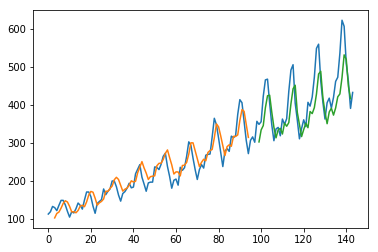

In [39]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()
